In [5]:
import os
import sys
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from clearml import Dataset

# Add parent directory to path to import our local modules
sys.path.insert(0, os.path.abspath('..'))

from data.dataset import MultiModalityDataset, load_dataset_and_dataloaders
from data.transforms import get_transforms
from data.utils import build_class_mapping, gather_samples, split_dataset, ensure_dataset_extracted
from data.visualization import show_batch

print("✅ Modules imported successfully.")

✅ Modules imported successfully.


## 1️⃣ Retrieve Dataset from ClearML

We have three versions of the dataset uploaded to ClearML. Select one to use.

In [6]:
# -----------------------------------------
# SELECT DATASET HERE
# -----------------------------------------
SELECTED_DATASET = "medium"  # Options: 'tiny', 'medium', 'large'
# -----------------------------------------

train_loader, val_loader, test_loader = load_dataset_and_dataloaders(dataset_size=SELECTED_DATASET)

📦 Loading ClearML dataset: medium (428add6db5904f48a46c7eb9888b5820)


██████████████████▋            65% | 160.00/247.79 MB [02:50<01:46,  1.21s/MB]: 

KeyboardInterrupt: 

## 4️⃣ Visualize Batch

Verify that images are loading correctly and augmentations are applied.

Visualizing Training Batch (with Augmentations):


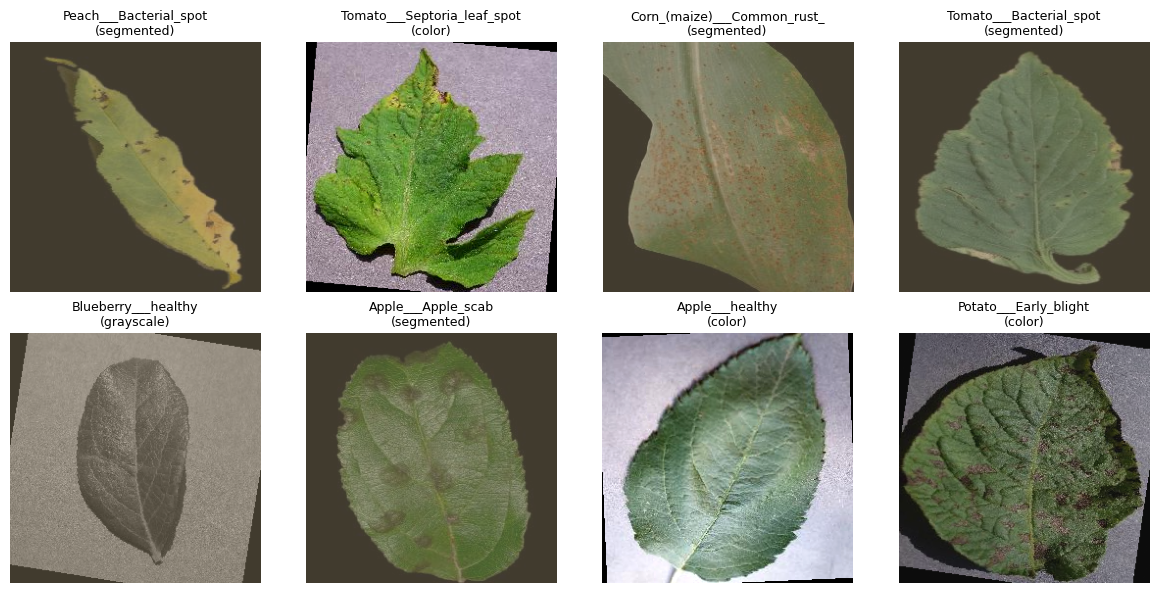

: 

In [ ]:
print("Visualizing Training Batch (with Augmentations):")
show_batch(train_loader, class_names, num_images=8, denorm=True)

## 5️⃣ Train a Tiny CNN

A quick training loop to verify the pipeline works end-to-end.

In [ ]:
# Define a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 224 -> 112
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 112 -> 56
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 56 -> 28
        )
        
        # Calculate flattened size based on input image size (assuming square images)
        # The image size is reduced by factor of 8 (three MaxPool2d(2) layers: 2*2*2=8)
        if isinstance(IMAGE_SIZE, int):
            h, w = IMAGE_SIZE, IMAGE_SIZE
        else:
            h, w = IMAGE_SIZE
            
        self.flatten_size = 64 * (h // 8) * (w // 8)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Setup Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"🚀 Training on {device} for 5 epochs...")

# Training Loop
for epoch in range(5):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch in train_loader:
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    print(f"Epoch [{epoch+1}/5] Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")

print("🏁 Training finished successfully!")

🚀 Training on cpu for 5 epochs...
